In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [179]:
data = pd.read_csv(
    r"C:\Users\yazid\Downloads\DFF(Daily).csv",
    sep=';',
    parse_dates=['DATE'],
    index_col='DATE'
)

In [180]:
data.columns

Index(['DFF'], dtype='object')

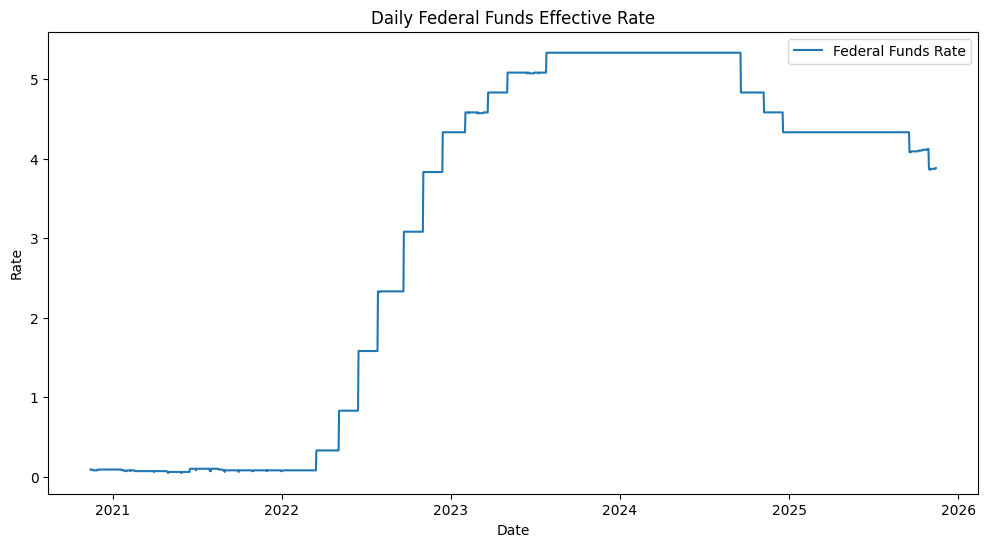

In [181]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['DFF'], label='Federal Funds Rate')
plt.title('Daily Federal Funds Effective Rate')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()

No clear seasonality!

PLOTTING THE MEAN AGAINST TIME TO SEE WHAT TYPE OF TREND WE EXACTLY HAVE

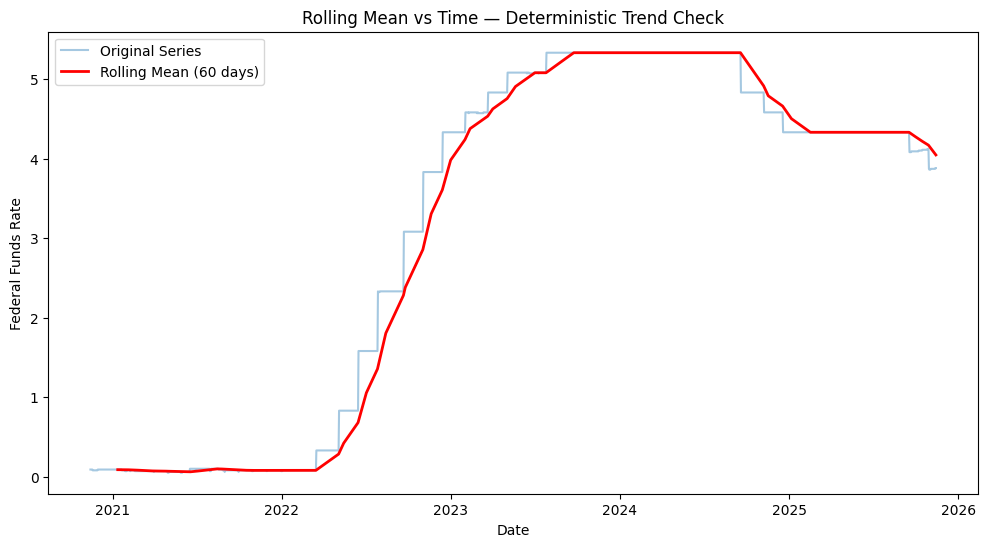

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# original series
plt.plot(data['DFF'], alpha=0.4, label='Original Series')

# rolling mean (choose window depending on frequency — here ~60 days)
rolling_mean = data['DFF'].rolling(window=60).mean()
plt.plot(rolling_mean, color='red', linewidth=2, label='Rolling Mean (60 days)')

plt.title("Rolling Mean vs Time — Deterministic Trend Check")
plt.xlabel("Date")
plt.ylabel("Federal Funds Rate")
plt.legend()
plt.show()

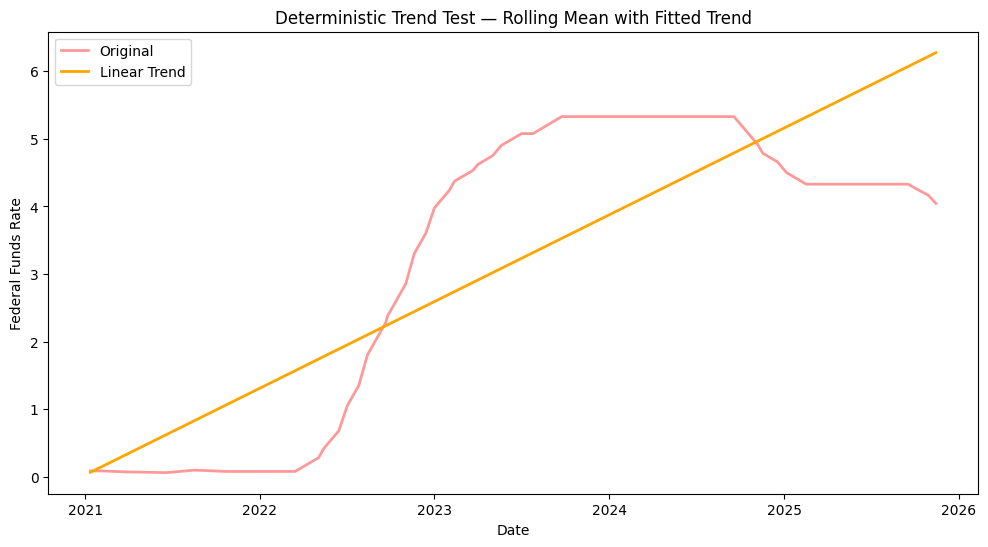

Trend slope: 0.0035133209895217552


In [183]:
import numpy as np
from sklearn.linear_model import LinearRegression
rolling_mean=rolling_mean.dropna()
X = np.arange(len(rolling_mean)).reshape(-1, 1)
y = rolling_mean.values

model = LinearRegression().fit(X, y)
trend = model.predict(X)

plt.figure(figsize=(12,6))
plt.plot(rolling_mean.index, rolling_mean, alpha=0.4, label='Original', color='red', linewidth=2)
plt.plot(rolling_mean.index, trend, color='orange', linewidth=2, label='Linear Trend')
plt.title("Deterministic Trend Test — Rolling Mean with Fitted Trend")
plt.xlabel("Date")
plt.ylabel("Federal Funds Rate")
plt.legend()
plt.show()
print("Trend slope:", model.coef_[0])

SLOPE NEARLY ZERO AND THE ROLLING MEAN OBVIOUSLY DOES NOT FOLLOW A LINEAR TREND => WE CAN CONLUDE THAT THE TREND IS NOT DETERMINISTIC IT IS IN FACT STOCHASTIC 
THE ORANGE LINE CAPTURES JUST THE OVERALL UPWARD MOVEMENT!

In [135]:
def adf_test(series):
    #Perform Augmented Dickey-Fuller test and print result
    result=adfuller(series.dropna())
    print('ADF Statistic : {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    if result[1]<0.05:
        print("Series is Likely Stationary")
        return True
    else:
        print("Series is Likely Non-Stationary")
        return False
print("ADF Test on Raw Series : ")
is_stationary=adf_test(data['DFF'])

ADF Test on Raw Series : 
ADF Statistic : -1.4971
p-value: 0.5350
Series is Likely Non-Stationary


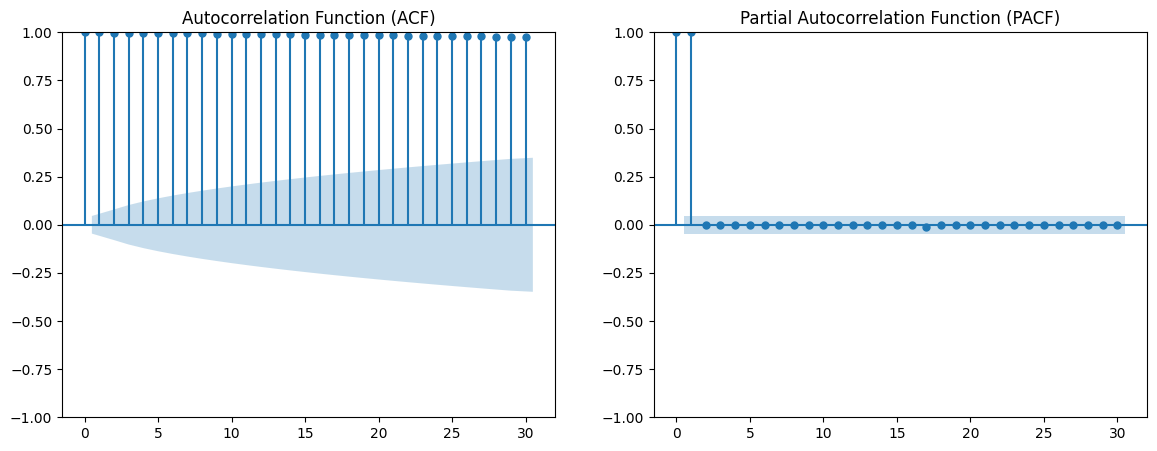

In [184]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plot_acf(data['DFF'], lags=30, ax=plt.gca(), alpha=0.05)  # alpha=0.05 gives 95% confidence bands
plt.title("Autocorrelation Function (ACF)")
plt.subplot(1,2,2)
plot_pacf(data['DFF'], lags=30, ax=plt.gca(), alpha=0.05, method='ywm')  # method='ywm' is stable
plt.title("Partial Autocorrelation Function (PACF)")

plt.show()

Interpretation of ACF (Autocorrelation Function)
All lags have autocorrelation ≈ 1.00, far outside the confidence bands.

This means the series is strongly autocorrelated across time, which is a classic sign of non-stationarity.

In a stationary series, autocorrelation should drop off quickly. Here, it stays high — suggesting a persistent trend or memory in the data.

In [185]:
#Apply First Differencing
if not is_stationary:
    data_diff=data['DFF'].diff().dropna()
    print("\nADF Test on First-Differenced Series: ")
    is_stationary_diff=adf_test(data_diff)


ADF Test on First-Differenced Series: 
ADF Statistic : -42.8727
p-value: 0.0000
Series is Likely Stationary


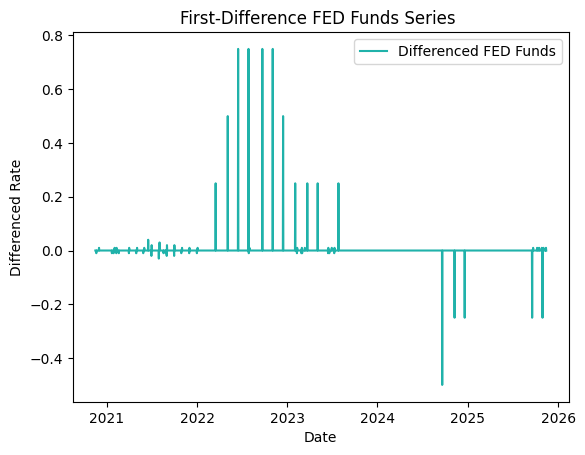

In [186]:
#Plot Differenced Series
if not is_stationary:
    plt.Figure(figsize=(12,6))
    plt.plot(data_diff,label='Differenced FED Funds',color="lightseagreen")
    plt.title('First-Difference FED Funds Series ')
    plt.xlabel('Date')
    plt.ylabel('Differenced Rate')
    plt.legend()
    plt.show()

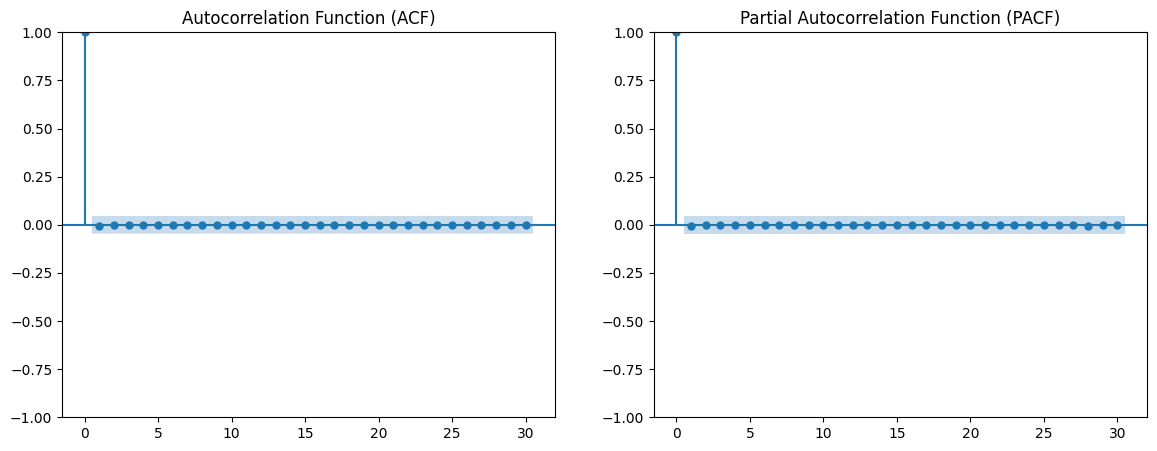

In [187]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plot_acf(data_diff, lags=30, ax=plt.gca(), alpha=0.05)  # alpha=0.05 gives 95% confidence bands
plt.title("Autocorrelation Function (ACF)")
plt.subplot(1,2,2)
plot_pacf(data_diff, lags=30, ax=plt.gca(), alpha=0.05, method='ywm')  # method='ywm' is stable
plt.title("Partial Autocorrelation Function (PACF)")

plt.show()

ACF (Autocorrelation Function) After Differencing
Lag 0 is 1.0, which is expected (a series is perfectly correlated with itself).

All other lags are near zero, and fall within the confidence bands.

This means: no significant autocorrelation remains → the series behaves like white noise.

PACF (Partial Autocorrelation Function) After Differencing
Lag 0 is 1.0, again expected.

All other lags are insignificant, within the confidence interval.

This suggests: no strong autoregressive structure beyond lag 0.

The differenced series is now stationary! 

But it also appears to be pure noise, with no clear AR or MA structure.

This implies that a simple ARIMA(0,1,0) model (random walk) might be sufficient — or that the series is not predictable using past values alone.

That does not sound sane! Here's another way to find p and q

In [188]:
from pmdarima import auto_arima

auto_arima(data, seasonal=False, d=1, max_p=5, max_q=5)

,order,"(0, ...)"
,seasonal_order,"(0, ...)"
,start_params,None
,method,'lbfgs'
,maxiter,50
,suppress_warnings,True
,out_of_sample_size,0
,scoring,'mse'
,scoring_args,{}
,trend,None
,with_intercept,True


EVEN AFTER USING ANOTHER METHOD OF AUTO ARIMA IT SUGGESTED ARIMA(0,1,0) ON ORIGINAL DATA

c:\Users\yazid\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\yazid\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\yazid\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


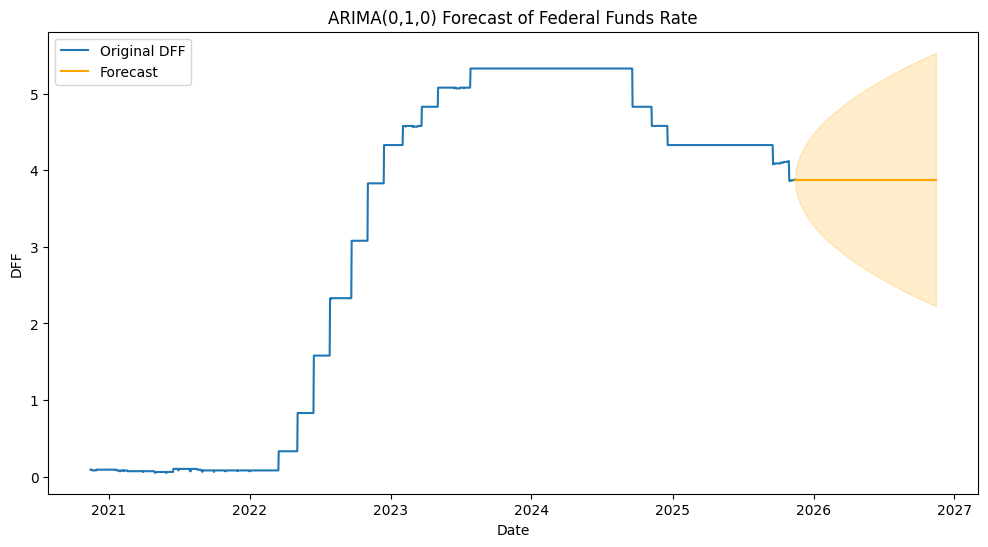

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# --- Fit ARIMA(0,1,0) ---
model = ARIMA(data, order=(0,1,0))
model_fit = model.fit()

# --- Forecast next Year ---
h = 365
forecast_obj = model_fit.get_forecast(steps=h)
forecast_mean = forecast_obj.predicted_mean       # Already in original scale
conf_int = forecast_obj.conf_int()                # Already in original scale

# --- Forecast index ---
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1),
                               periods=h, freq='D')

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(data.index, data, label='Original DFF')
plt.plot(forecast_index, forecast_mean.values, color='orange', label='Forecast')
plt.fill_between(forecast_index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color='orange', alpha=0.2)
plt.title('ARIMA(0,1,0) Forecast of Federal Funds Rate')
plt.xlabel('Date')
plt.ylabel('DFF')
plt.legend()
plt.show()
